# Longest Common Subsequence


The problem of finding the [Longest Common
Subsequence](https://en.wikipedia.org/wiki/Longest_common_subsequence) between
two sequences finds numerous applications in fields as diverse as computer
sciences or bioinformatics. In this example, we'll implement a parallel
dynamic programming approach to solving such problems.

The idea behind this approach is that, if we denote by $LCS(X,Y)$ the longest
common subsequence of two sequences $X$ and $Y$, then $LCS$ satisfies the two
following properties:

$$
\begin{align}
& LCS(X*c, Y*c) = LCS(X, Y) * c \\
& LCS(X*c_1, Y*c_2) \in \left\{ LCS(X*c_1, Y), LCS(X, Y*c_2)\right\} & \text{if } c_1 \neq c_2
\end{align}
$$

where $X*c$ denotes the concatenation of sequence $X$ with character $c$. The
first property above allows simplifying the Longest Common Subsequence
computation of two sequences that end with the same character. When the two
sequences end with different characters, the second property allows
simplifying the problem to a choice between two possibilities.

If we now denote by $L_{i,j}$ the length of the longest common subsequence
between the first $i$ characters of $X$ and the first $j$ characters of $Y$,
then we now have the following property for $L$:

$$
L_{i,j} = \left\{
\begin{array}{ll}
0 & \text{ if } i=0 \text{ or } j=0\\
1 + L_{i-1, j-1} & \text{ if } i\neq 0 \text{ and } j\neq 0 \text{ and } x_i = y_j\\
\text{max}\left(L_{i-1, j}, L_{i,j-1}\right) & \text{ if } i\neq 0 \text{ and } j\neq 0 \text{ and } x_i \neq y_j\\
\end{array}
\right.
$$

where $x_i$ represents the $i$-th character in sequence $X$ and $y_j$ the $j$-th character in sequence $Y$.

If $L$ is stored in an array, the first condition above allows initializing
its first row and first column. Then, the neighboring cells can be filled
using the two other conditions, which in turn unlocks further neighboring
cells until the whole $L$ matrix is filled.

## Small example

Let us begin with a small example: we want to find a longest common subsequence between `GAC` and `AGCAT`:

In [1]:
x = collect("GAC");
y = collect("AGCAT");

Let's build the $L$ array. For the sake of the example, we'll initially fill
it with $(-1)$ in order to indicate which values haven't been computed yet. The
`init_length!` function fills the first row and the first column in the
array. We also define a `display` helper function, which shows a pretty
representation of the $L$ array.

In [2]:
function init_lengths!(L, x, y)
    L[1,1] = 0
    for i in eachindex(x)
        L[i+1, 1] = 0
    end
    for j in eachindex(y)
        L[1, j+1] = 0
    end
end

using PrettyTables
display(L, x, y) = pretty_table(hcat(['∅', x...], L);
                                header = [' ', '∅', y...],
                                formatters = (v, i, j) -> v==-1 ? "" : v)

L = -ones(Int, 1+length(x), 1+length(y))
init_lengths!(L, x, y)
display(L, x, y)

┌───┬───┬───┬───┬───┬───┬───┐
│   │ ∅ │ A │ G │ C │ A │ T │
├───┼───┼───┼───┼───┼───┼───┤
│ ∅ │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
│ G │ 0 │   │   │   │   │   │
│ A │ 0 │   │   │   │   │   │
│ C │ 0 │   │   │   │   │   │
└───┴───┴───┴───┴───┴───┴───┘


The `fill_lengths!` function then allows filling other rows. By default it
will fill the entire array, but for the sake of the example we restrict it
here to a subset of the rows and/or the columns.

In [3]:
function fill_lengths!(L, x, y, ir=eachindex(x), jr=eachindex(y))
    for j in jr
        for i in ir
            L[i+1, j+1] = if x[i] == y[j]
                L[i, j] + 1
            else
                max(L[i+1, j], L[i, j+1])
            end
        end
    end
end

fill_lengths!(L, x, y, 1:1)
display(L, x, y)

┌───┬───┬───┬───┬───┬───┬───┐
│   │ ∅ │ A │ G │ C │ A │ T │
├───┼───┼───┼───┼───┼───┼───┤
│ ∅ │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
│ G │ 0 │ 0 │ 1 │ 1 │ 1 │ 1 │
│ A │ 0 │   │   │   │   │   │
│ C │ 0 │   │   │   │   │   │
└───┴───┴───┴───┴───┴───┴───┘


After the first row has been filled, we see that $L_{1,1} = 0$ because we
can't extract any common subsequence from the first characters in $X$ (`G`)
and $Y$ (`A`). However, $L_{1,2}=1$ because the first character of $X$ (`G`)
matches the second character of $Y$ (which is also `G`). In turn this causes
all other $L_{1,j}$ values to be equal to 1.

Now that the first row is complete, we can fill the remaining two rows in the
array:

In [4]:
fill_lengths!(L, x, y, 2:3)
display(L, x, y)

┌───┬───┬───┬───┬───┬───┬───┐
│   │ ∅ │ A │ G │ C │ A │ T │
├───┼───┼───┼───┼───┼───┼───┤
│ ∅ │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
│ G │ 0 │ 0 │ 1 │ 1 │ 1 │ 1 │
│ A │ 0 │ 1 │ 1 │ 1 │ 2 │ 2 │
│ C │ 0 │ 1 │ 1 │ 2 │ 2 │ 2 │
└───┴───┴───┴───┴───┴───┴───┘


We now know that the longest common subsequence between $X$ and $Y$ has a
length of 2. In order to actually find a subsequence of this length, we can
"backtrack" from the bottom right of the array back to the top left:

In [5]:
function backtrack(L, x, y)
    i = lastindex(x)
    j = lastindex(y)
    subseq = Char[]
    while L[i+1, j+1] != 0
        if x[i] == y[j]
            pushfirst!(subseq, x[i])
            (i, j) = (i-1, j-1)
        elseif L[i+1, j] > L[i, j+1]
            (i, j) = (i, j-1)
        else
            (i, j) = (i-1, j)
        end
    end
    String(subseq)
end

backtrack(L, x, y)

"GA"

Wrapping everything into a function, we get

In [6]:
function LCS(x, y)
    L = Matrix{Int}(undef, 1+length(x), 1+length(y))
    init_lengths!(L, x, y)
    fill_lengths!(L, x, y)
    backtrack(L, x, y)
end

LCS(x, y)

"GA"

## Large example

Let's test this on larger data. The results obtained with this sequential
version of the algorithm will serve as reference to check the validity of more
complex implementations.

In [7]:
import Random; Random.seed!(42)
x = rand("ATCG", 4096);
y = rand("ATCG", 8192);
seq = LCS(x, y)
length(seq)

3575

### Tiled sequential version

We'll now build a tiled version of the same algorithm. The following helper
function allows splitting a range of indices into a given number of chunks.

In [8]:
function splitrange(range, nchunks)
    q, r = divrem(length(range), nchunks)
    chunks = UnitRange{Int}[]

    i₁ = first(range)
    for k in 1:nchunks
        n = k <= r ? q+1 : q
        i₂ = i₁ + n
        push!(chunks, i₁:i₂-1)
        i₁ = i₂
    end
    chunks
end

splitrange(1:20, 3) # split the range 1:20 into 3 chunks of equal sizes

3-element Vector{UnitRange{Int64}}:
 1:7
 8:14
 15:20

A tiled version of the previous algorithm is then as simple as filling the
chunks one after the other (which, as we'll see later, can already be
beneficial in terms of performance because it is more cache-friendly):

In [9]:
function LCS_tiled(x, y, nx, ny)
    L = Matrix{Int}(undef, 1+length(x), 1+length(y))
    init_lengths!(L, x, y)

    for irange in splitrange(eachindex(x), nx)
        for jrange in splitrange(eachindex(y), ny)
            fill_lengths!(L, x, y, irange, jrange)
        end
    end

    backtrack(L, x, y)
end

LCS_tiled (generic function with 1 method)

Here we split the problem into $8 \times 12$ blocks, and check that the tiled
version gives the same results as the plain implementation above.

In [10]:
nx = 8
ny = 12
tiled = LCS_tiled(x, y, nx, ny)
@assert seq == tiled

## Tiled parallel version

Parallelizing the tiled version using `DataFlowTasks` is now very
straightforward: it only requires annotating the code to expose data
dependencies.

In our case:
- the initialization task writes to the whole `L` array;
- filling a tile involves reading `L` for the provided ranges of indices, and writing to a
  range of indices shifted by 1;
- backtracking reads the whole `L` array.

Note that the backtracking task needs to be fetched in order to get the result
in a synchronous way and perform an apple-to-apple comparison to the previous
implementations.

In [11]:
using DataFlowTasks

function LCS_par(x, y, nx, ny)
    L = Matrix{Int}(undef, 1+length(x), 1+length(y))
    DataFlowTasks.@spawn init_lengths!(@W(L), x, y) label="init"

    kx = 0
    for irange in splitrange(eachindex(x), nx)
        kx += 1; ky = 0
        for jrange in splitrange(eachindex(y), ny)
            ky += 1
            DataFlowTasks.@spawn begin
                @R view(L, irange, jrange)
                @W view(L, irange .+ 1, jrange .+ 1)
                fill_lengths!(L, x, y, irange, jrange)
            end label="tile ($kx, $ky)"
        end
    end

    bt = DataFlowTasks.@spawn backtrack(@R(L), x, y) label="backtrack"
    fetch(bt)
end

LCS_par (generic function with 1 method)

Again, we can check that this implementation produces the same results:

In [12]:
par = LCS_par(x, y, nx, ny)
@assert seq == par

As an added safety measure, let's collect some more data to check the correctness of the task dependency graph:

In [13]:
resize!(DataFlowTasks.get_active_taskgraph(), 200)
log_info = DataFlowTasks.@log LCS_par(x, y, nx, ny)

LogInfo with 98 logged tasks
	 critical time: 0.56 seconds

we can now confirm that the graph looks as expected:

Status `~/.julia/scratchspaces/d1549cb6-e9f4-42f8-98cc-ffc8d067ff5b/weakdeps-1.9/Project.toml`
  [13f3f980] CairoMakie v0.10.11
  [e9467ef8] GLMakie v0.8.11
  [f526b714] GraphViz v0.2.0
  [ee78f7c6] Makie v0.19.11


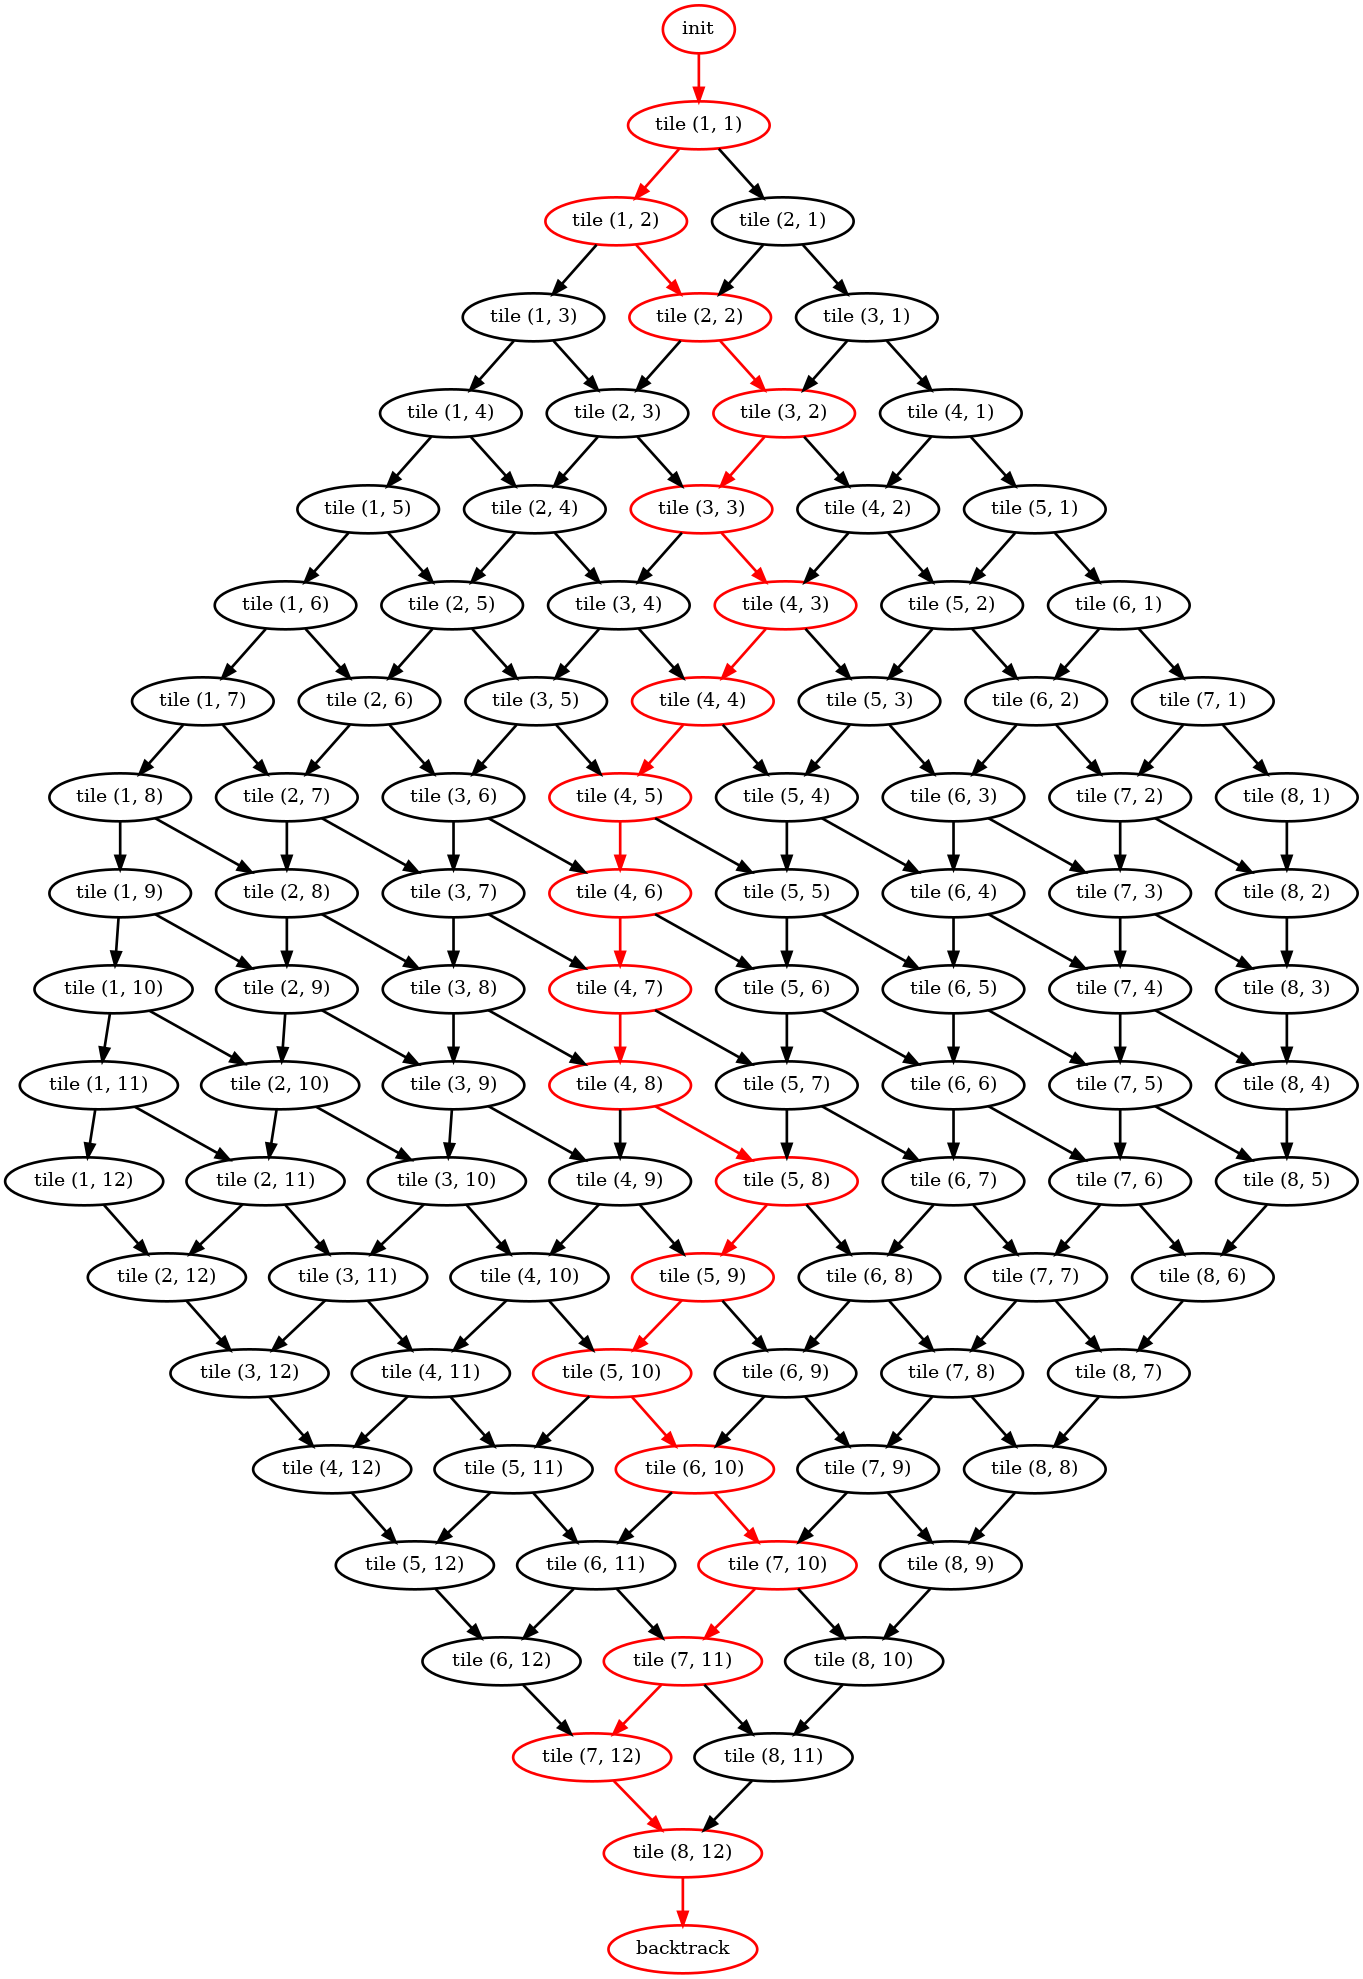

In [14]:
DataFlowTasks.stack_weakdeps_env!()
using GraphViz
dag = GraphViz.Graph(log_info)

## Performance comparison

Comparing the performances of these 3 implementations shows that the tiled
version already saves some time due to cache effects.

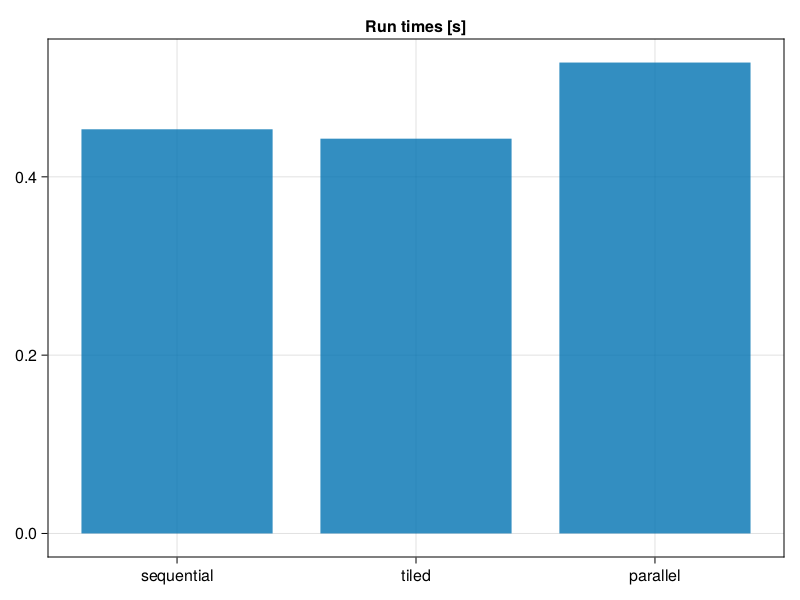

In [15]:
GC.gc(); t_seq   = @elapsed LCS(x, y)
GC.gc(); t_tiled = @elapsed LCS_tiled(x, y, nx, ny)
GC.gc(); t_par   = @elapsed LCS_par(x, y, nx, ny)

using CairoMakie
barplot(1:3, [t_seq, t_tiled, t_par],
        axis = (; title = "Run times [s]",
                xticks = (1:3, ["sequential", "tiled", "parallel"])))

The speed-up of the parallel version does not seem ideal, however:

In [16]:
speedup  = t_tiled / t_par
nthreads = Threads.nthreads()
(; speedup, nthreads)

(speedup = 0.8383372117392909, nthreads = 8)

 Let's try and understand why. The run-time data collected above can help build
a profiling plot, which gives some insight about the performances of our
parallel version:

[ Info: Computing    : 2.5232052600000006
[ Info: Inserting    : 0.0007478300000000003
[ Info: Other        : 1.9409909252570596


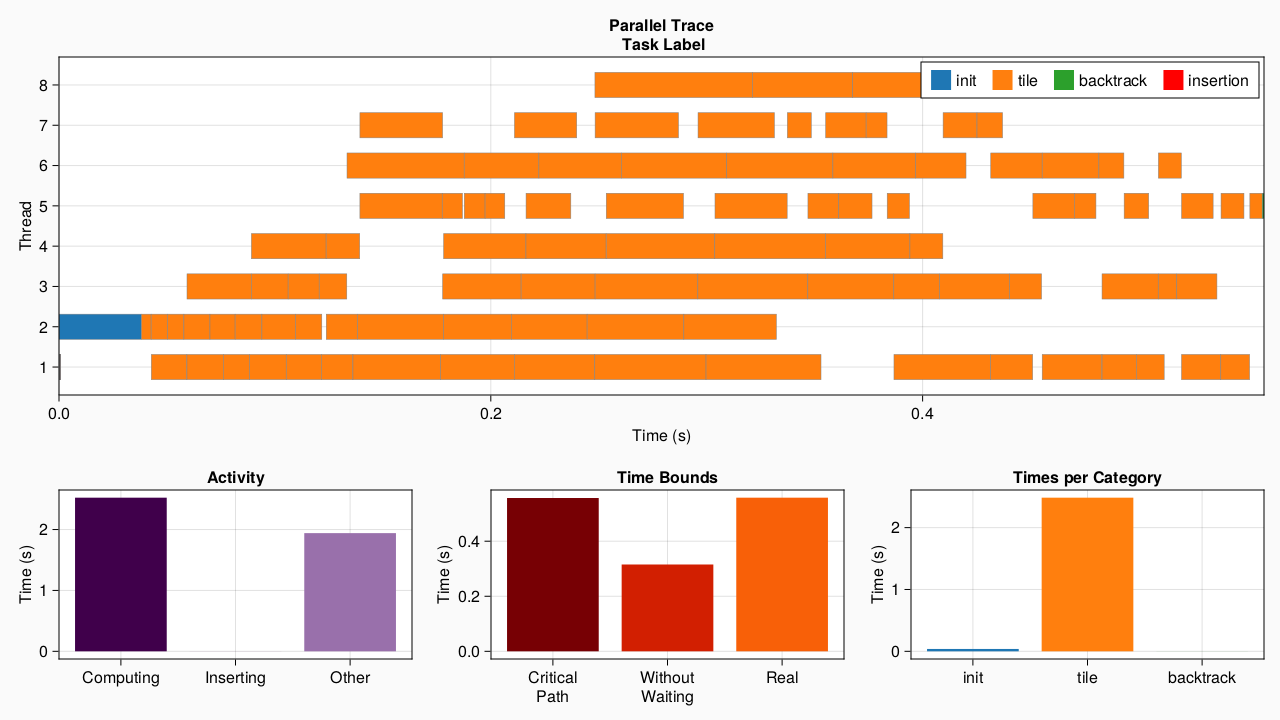

In [17]:
plot(log_info, categories=["init", "tile", "backtrack"])

Here, we see for example that the run time is bounded by the length of the
critical path. Adding more threads would not help, but perhaps dividing the
problem into smaller chunks could help.

It also appears that a non-negligible fraction of the time is spent in the
initialization of the array, which is mostly memory allocation time. In order
to improve this, we would need a "real" tiled array in which blocks can be
allocated independently from one another.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*